#**Reuters-21578 News classification**

*Abdellah BOUSBA - 20-11-2021*

In [ ]:
#extract data with /content/DATA path to distination folder
!7za x -y DATA.7z -o/content/DATA

##Data exploration :

###Data parser :
extract information from each field of the raw data by iterating all 22 segments to create documents.

In [2]:
!pip -q install xmltodict 

In [2]:
relevent_topics = ["money-fx", "ship" , "interest" , "acq" , "earn"]

class Document:
  # Document class contains informations about a specific document.

  def __init__(self,id,title,text,topic,split):
    self.id = id      # unique for each document
    self.title = title    # the title of the document
    self.text = text      # the body of the document
    self.topic = topic    # list that can contain (MONEY-FX) , (SHIP) , (INTEREST) , (ACQ) , (EARN)
    self.split = split    # takes train or test values to indicates if the document belongs to train dataset or test dataset

  def getId(self):
    return self.id      

  def getTitle(self):
    return self.title

  def getText(self):
    return self.text

  def getTopic(self):
    return self.topic  

  def getSplit(self):
    return self.split  

In [3]:
import  os 
import xmltodict
import re

path = 'DATA/'      #the path of data
all_docs = []

for name in os.listdir(path):   # for each file in path 
  if name.endswith(".sgm"):     # check if its a sgm file
    with open(path+name,'r', errors='ignore') as f:     # ignore errors of bad formating 
      f.readline()                    #skip first line
      contents = "<all>"+f.read()+"</all>"    #read all text and add big container
      d = re.sub(r'&#([a-zA-Z0-9]+);?', r'[#\1;]', contents)    #replace forbidden characters for xml (&#num) to prevents errors in parsing
      d = xmltodict.parse(d)      # use xmltodict to create dictionary of documents
      for document in d["all"]["REUTERS"]:    #extract relevent information for each document

        id = document["@NEWID"]
        split = document["@LEWISSPLIT"]


        # in case we dont have information about text
        title = ""  
        body = ""

        if "TEXT" in document:
          if "TITLE" in document["TEXT"]:
            title = document["TEXT"]["TITLE"]
          if "BODY" in document["TEXT"]:
            body = document["TEXT"]["BODY"]


        topic = document["TOPICS"]

        if topic is not None:   #check that we have label
          topic = topic["D"]

          #each document can have multiple topics 
          if type(topic) != list:   
            topic = [topic]
          topic = [x for x in topic if x in ["money-fx", "ship" , "interest" , "acq" , "earn"]] #filter 5 relevent topics acording to the task

          all_docs += [Document(id,title,body,topic,split)] #add document to the list


###Class balance:

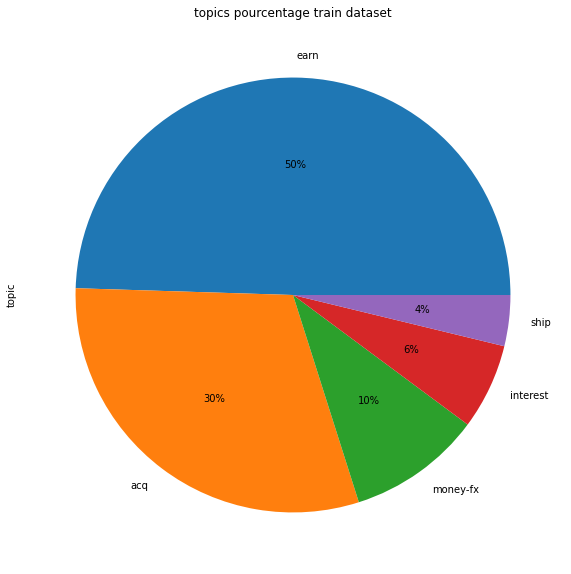

In [6]:
# plot percentage of each class

import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
df_documents.explode("topic")["topic"].value_counts().plot(kind='pie',autopct='%1.0f%%')
plt.title("topics pourcentage train dataset")
plt.show()

In [4]:
#calculate the number or labeled/unlabeled data
import pandas as pd 

df_documents = pd.DataFrame.from_records([d.__dict__ for d in all_docs])

num_unlabeled = len(df_documents[df_documents["topic"].astype(str) == '[]'])
num_labeled = len(df_documents[df_documents["topic"].astype(str) != '[]'])

print("number of unlabeled data : {} = {:.2f} %".format(num_unlabeled,num_unlabeled/(num_unlabeled+num_labeled)*100))
print("number of labeled data : {} = {:.2f} %".format(num_labeled,num_labeled/(num_unlabeled+num_labeled)*100))

df_documents = df_documents[df_documents["topic"].astype(str) != '[]']

number of unlabeled data : 3543 = 31.17 %
number of labeled data : 7824 = 68.83 %


In [5]:
df_documents.topic.astype(str).unique()

array(["['acq']", "['money-fx']", "['interest', 'money-fx']", "['earn']",
       "['interest']", "['ship']", "['money-fx', 'interest']",
       "['earn', 'acq']", "['acq', 'ship']", "['acq', 'earn']",
       "['ship', 'acq']", "['earn', 'ship']", "['money-fx', 'acq']"],
      dtype=object)

##Topics characteristics  


	top words for money-fx:



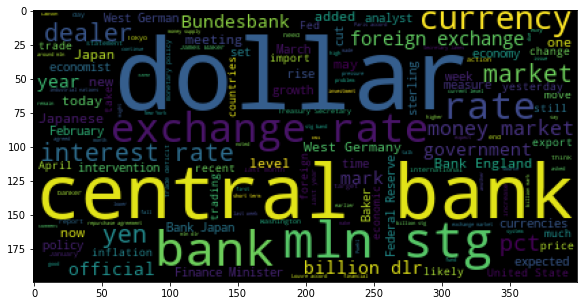


	top words for ship:



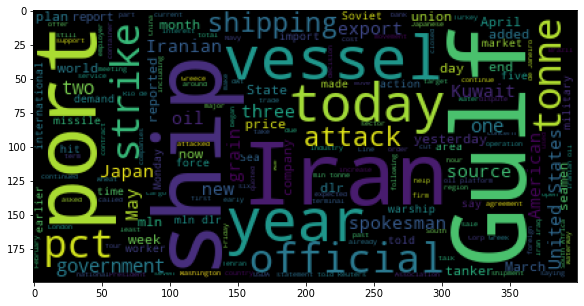


	top words for interest:



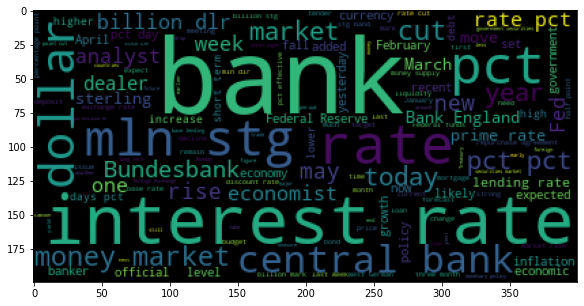


	top words for acq:



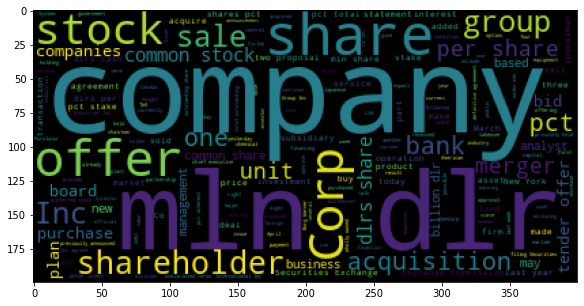


	top words for earn:



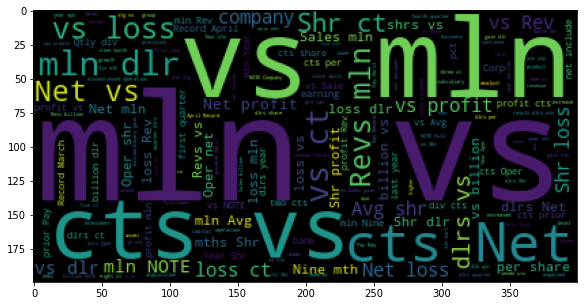

In [7]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS) 
mystopwords = frozenset({'reuter', 'said', 'will'})
stopwords = stopwords.union(mystopwords)


for topic in ["money-fx", "ship" , "interest" , "acq" , "earn"]:
  wc = WordCloud(stopwords = stopwords).generate(' '.join(df_documents.explode("topic")[df_documents.explode("topic")["topic"] == topic]['text']))
  print("\n======================================\n\ttop words for "+topic+":\n======================================\n")
  plt.figure(figsize=(10,5))
  plt.imshow(wc)
  plt.show()

##Creating the training and test dataset :



In [8]:
# we take the title and body as input data and a one hot vector of len 5 to represent topics
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=relevent_topics)

# for the train and test data we take the LEWISSPLIT of our raw data into considerartion and split accordingly
uncleaned_train = df_documents[df_documents["split"] == "TRAIN"].copy()
uncleaned_train['X'] = df_documents[df_documents["split"] == "TRAIN"]["title"] + df_documents[df_documents["split"] == "TRAIN"]["text"]
uncleaned_train['Y'] = list(mlb.fit_transform(df_documents[df_documents["split"] == "TRAIN"]["topic"]))
uncleaned_train = uncleaned_train[["X","Y"]]

uncleaned_test = df_documents[df_documents["split"] == "TEST"].copy()
uncleaned_test['X'] = df_documents[df_documents["split"] == "TEST"]["title"] + df_documents[df_documents["split"] == "TEST"]["text"]
uncleaned_test['Y'] = list(mlb.fit_transform(df_documents[df_documents["split"] == "TEST"]["topic"]))
uncleaned_test = uncleaned_test[["X","Y"]]

##Clean up the data


*   remove ponctuation
*   remove stopwords
*   stemming



In [9]:
import nltk 
from nltk.tokenize import word_tokenize
import string


nltk.download('punkt')

def cleanup(text):
  text_new = "".join([i for i in text if i not in string.punctuation]) #remove punct

  words = word_tokenize(text_new)
  words_new = [i for i in words if i not in stopwords]  #remove stopwords

  ss = nltk.SnowballStemmer(language = 'english') # keep only stem of the words
  w = [ss.stem(word) for word in words_new]

  return ' '.join(w)  #return a single string of joint words seperated by space

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
#constructing cleaned data
cleaned_train = uncleaned_train.copy()
cleaned_train['X'] = [cleanup(x) for x in uncleaned_train['X']] #we clean each document

cleaned_test = uncleaned_test.copy()
cleaned_test['X'] = [cleanup(x) for x in uncleaned_test['X']] #we clean each document


In [11]:
cleaned_train

,X,Y
1826,champion product ch approv stock splitchampion...,"[0, 0, 0, 0, 1]"
1827,comput termin system cpml complet salecomput t...,"[0, 0, 0, 1, 0]"
1828,cobanco inc cbco year netshr 34 cts vs 119 dlr...,"[0, 0, 0, 0, 1]"
1829,ohio mattress omt may have lower 1st qtr netoh...,"[0, 0, 0, 1, 1]"
1830,am intern inc am 2nd qtr jan 31oper shr loss t...,"[0, 0, 0, 0, 1]"
...,...,...
11362,knightridd inc krn set quarterlyqt div 25 cts ...,"[0, 0, 0, 0, 1]"
11363,technitrol inc tnl set quarterlyqt div 12 cts ...,"[0, 0, 0, 0, 1]"
11364,nationwid cellular servic inc ncel 4th qtrshr ...,"[0, 0, 0, 0, 1]"
11365,aha automot technolog corp year netshr 43 cts ...,"[0, 0, 0, 0, 1]"


##Input length :

In [12]:
#we calculate the maximum length of documents
lengths = [len(word_tokenize(x)) for x in cleaned_train['X']] + [len(word_tokenize(x)) for x in cleaned_test['X']]
h = sorted(lengths)[-1]  #sorted lengths
print("max input length is: ",h)

max input length is:  583


##SVM model :

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import time

from time import process_time

#function to calculate time
def tic():
    global mytime
    mytime = process_time()
def tac():
    global mytime
    print (process_time()-mytime)
    mytime = process_time()


def get_score_classes(y,true_y,metric):
  # function that plot the specified metric for each topic using y as predicted labels and true_y as correct labels
  scores = classification_report(true_y, y, output_dict=True) #get the classification report 
  scores = [scores[str(i)][metric] for i in range(len(relevent_topics))]  #retreive only the metric we want
  plt.figure()
  plt.barh(relevent_topics,scores) # plot results
  for i, v in enumerate(scores):
      plt.text(v*0.8, i , str(round(v*100,2))+" %", color='black', fontweight='bold')   #add score on the plot
  plt.xlabel(metric)
  plt.ylabel("labels")
  plt.title(metric+" for each class")
  plt.show()

def train_predict(model,X,y,X_test,y_test):
  model.fit(X, y)  # training of train dataset 
  Y_test_predict = model.predict(X_test)  #predict labels for test

  #calculate f1 score and accuracy 
  f1 = f1_score(y_test, Y_test_predict,average="samples")  #calculate f1-score
  accuracy = accuracy_score(y_test, Y_test_predict) #calculate accuracy
  print("accuracy : {:.2f}, F1 : {:.2f}".format(accuracy*100,f1*100))
  
  get_score_classes(Y_test_predict,y_test,"f1-score")  # plot f1 score for each class

def grid_search(classif,x,y,params):

    clf = GridSearchCV(classif, params, cv=5,scoring=f1_score) #grid search for 5 folds using f1 score
    clf.fit(x, y)
    #return best paramas
    return clf.best_params_



unbalanced : 
accuracy : 93.89, F1 : 95.47


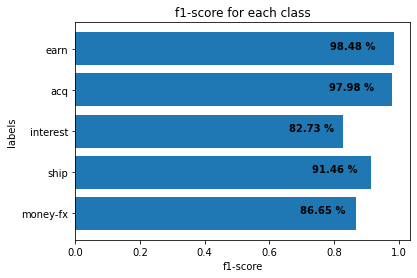

16.013633907999974

with balanced weights : 
accuracy : 94.31, F1 : 96.50


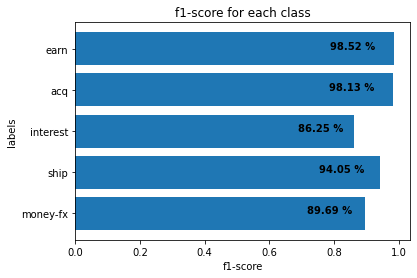

17.890748292999888


In [29]:

#creation of tf-idf vectors
vect = TfidfVectorizer()
X = vect.fit_transform(cleaned_train['X'])  # create the vocabulary and then the training vectors
X_test = vect.transform(cleaned_test['X'])  # create the test vectors

#training with unbalanced weights (original)
print("\nunbalanced : ")
tic()
classif = OneVsRestClassifier(SVC(kernel='linear')) #use oneVsAll method and default hyperparams
train_predict(classif,X,list(cleaned_train['Y']),X_test,list(cleaned_test['Y']))
tac()

#training with balanced weights to solve unbalanced data problem
print("\nwith balanced weights : ")
tic()
classif = OneVsRestClassifier(SVC(kernel='linear',class_weight='balanced'))
train_predict(classif,X,list(cleaned_train['Y']),X_test,list(cleaned_test['Y']))
tac()

###Hyperparameters optimization:

In [183]:

#define what hyperparameters to use
params = {'estimator__kernel': ["linear","rbf","sigmoid"],
    'estimator__C': [1.0, 10.0, 100.0],
    'estimator__gamma' : ['auto', 'scale', 0.01, 1.0]
    }

classif = OneVsRestClassifier(SVC(class_weight='balanced'))
grid_search(classif,X, list(cleaned_train['Y']), params)

{'estimator__C': 1.0,
 'estimator__gamma': 'auto',
 'estimator__kernel': 'linear'}

accuracy : 94.31, F1 : 96.50


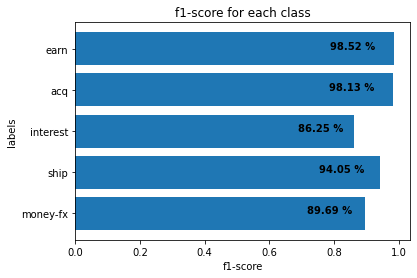

In [91]:
#training using optimal params
classif = OneVsRestClassifier(SVC(kernel='linear',gamma='auto',C=1,class_weight='balanced'))
train_predict(classif,X,list(cleaned_train['Y']),X_test,list(cleaned_test['Y']))

##Logistic Regression :


unbalanced : 
accuracy : 88.95, F1 : 90.18


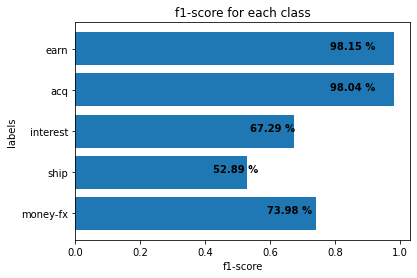

3.418280253000006

with balanced weights : 
accuracy : 93.34, F1 : 96.48


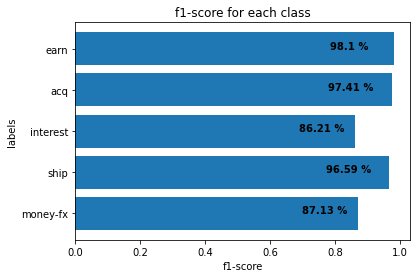

3.8552335930000083


In [16]:
from sklearn.linear_model import LogisticRegression

#training with unbalanced weights (original)
print("\nunbalanced : ")
tic()
classif = OneVsRestClassifier(LogisticRegression()) #use oneVsAll method and default hyperparams
train_predict(classif,X,list(cleaned_train['Y']),X_test,list(cleaned_test['Y']))
tac()

#training with balanced weights to solve unbalanced data problem
print("\nwith balanced weights : ")
tic()
classif = OneVsRestClassifier(LogisticRegression(class_weight='balanced'))
train_predict(classif,X,list(cleaned_train['Y']),X_test,list(cleaned_test['Y']))
tac()

##Transformers :

The use of GPU in this part is highly recommended.

In [17]:
!pip -q install transformers

###use first 200 word trunc : 

In [18]:
num_labels = len(relevent_topics) #number of topics

In [19]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from tqdm import tqdm, trange
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#device cuda device for GPU use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [20]:
max_length = 200  # max number of words

#create token vectors for bert 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) # tokenizer
encodings = tokenizer.batch_encode_plus(list(cleaned_train['X']),max_length=max_length,pad_to_max_length=True) # tokenizer's encoding method

input_ids = encodings['input_ids'] # tokenized and encoded sentences
token_type_ids = encodings['token_type_ids'] # token type ids
attention_masks = encodings['attention_mask'] # attention masks

labels = list(cleaned_train["Y"]) #train labels

encodings = tokenizer.batch_encode_plus(list(cleaned_test['X']),max_length=max_length,pad_to_max_length=True) # tokenizer's encoding method

test_inputs = encodings['input_ids'] # tokenized and encoded sentences
test_token_types = encodings['token_type_ids'] # token type ids
test_masks = encodings['attention_mask'] # attention masks

test_labels = list(cleaned_test["Y"]) #test labels

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [21]:
#split validation set to control training
train_inputs, validation_inputs,\
train_labels, validation_labels,\
train_token_types, validation_token_types,\
train_masks, validation_masks = train_test_split(input_ids, labels, token_type_ids,attention_masks,random_state=6969, test_size=0.10)


# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
validation_token_types = torch.tensor(validation_token_types)

test_inputs = torch.tensor(test_inputs)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_masks)
test_token_types = torch.tensor(test_token_types)

In [22]:
# Select a batch size for training. 
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_types)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels, test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [ ]:
#load a pretrained 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
model.cuda()    #load if into gpu

optimizer = AdamW(model.parameters(),lr=2e-5,correct_bias=True) 

###Finetuning the model :

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]


Train loss: 0.24454269964586606


Epoch:  12%|█▎        | 1/8 [06:35<46:11, 395.87s/it]


F1 Validation Accuracy:  93.45565749235473

Train loss: 0.08700065553043183


Epoch:  25%|██▌       | 2/8 [13:13<39:40, 396.67s/it]


F1 Validation Accuracy:  96.1467889908257

Train loss: 0.05258689024304221


Epoch:  38%|███▊      | 3/8 [19:50<33:04, 396.97s/it]


F1 Validation Accuracy:  96.1467889908257

Train loss: 0.038637436490941354


Epoch:  50%|█████     | 4/8 [26:27<26:28, 397.05s/it]


F1 Validation Accuracy:  96.20795107033639

Train loss: 0.033176744991744105


Epoch:  62%|██████▎   | 5/8 [33:04<19:50, 396.91s/it]


F1 Validation Accuracy:  97.30886850152906

Train loss: 0.02663907175278896


Epoch:  75%|███████▌  | 6/8 [39:40<13:13, 396.72s/it]


F1 Validation Accuracy:  97.06422018348624

Train loss: 0.02239476365351735


Epoch:  88%|████████▊ | 7/8 [46:17<06:36, 396.63s/it]


F1 Validation Accuracy:  96.75840978593271

Train loss: 0.020664417184889317


Epoch: 100%|██████████| 8/8 [52:53<00:00, 396.69s/it]


F1 Validation Accuracy:  97.30886850152906



F1 Test Accuracy:  97.65649090348441


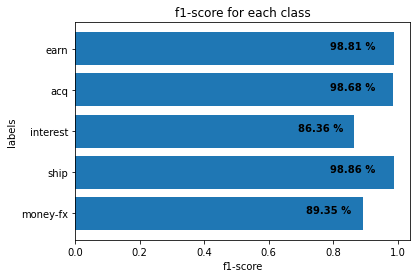

3229.3396516509997


In [24]:
import copy

epochs = 8
best_f1 = 0

tic()
# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training
  
  # Set our model to training mode 
  model.train()

  # Tracking variables
  tr_loss = 0 #running loss
  nb_tr_steps = 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # Forward pass for multilabel classification
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    loss_func = BCELoss() 
    loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
 

    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_steps += 1
    #empty gpu memory
    del batch
    del b_input_ids
    del b_input_mask
    del b_labels
    del b_token_types
    torch.cuda.empty_cache()
  print("\nTrain loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Variables to gather full output
  logit_preds,true_labels,pred_labels = [],[],[]

  # Predict
  for i, batch in enumerate(validation_dataloader):
    # Put batch into gpu
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    # keep track of results
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

    #empty gpu memory
    del batch
    del b_input_ids
    del b_input_mask
    del b_labels
    del b_token_types
    torch.cuda.empty_cache()

  # Flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # Calculate Accuracy
  threshold = 0.50
  pred_labels = [list(map(lambda x: int(x),pl>threshold)) for pl in pred_labels]  # document belong to class when higher than threshold

  val_f1_accuracy = f1_score(true_labels,pred_labels,average='samples')*100
  if val_f1_accuracy > best_f1:
    best_model = copy.deepcopy(model)   #keep best model according to f1 score
  print('\nF1 Validation Accuracy: ', val_f1_accuracy)

###############################################################################

# Test

best_model.eval()

# Variables to gather full output
logit_preds,true_labels,pred_labels = [],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
  #load batch into gpu
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels, b_token_types = batch
  with torch.no_grad():
    # Forward pass
    outs = best_model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)

    pred_label = pred_label.to('cpu').numpy()
    b_labels = b_labels.to('cpu').numpy()

  true_labels.append(b_labels)
  pred_labels.append(pred_label)

  #empty gpu memory
  del batch
  del b_input_ids
  del b_input_mask
  del b_labels
  del b_token_types
  torch.cuda.empty_cache()

# Flatten outputs
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]

# Calculate Accuracy
threshold = 0.50
pred_labels = [list(map(lambda x: int(x),pl>threshold)) for pl in pred_labels]

val_f1_accuracy = f1_score(true_labels,pred_labels,average='samples')*100

print('\nF1 Test Accuracy: ', val_f1_accuracy)

get_score_classes(pred_labels,true_labels,"f1-score")

tac()

##Models comparesion :

In [25]:
comp = {'Model':['SVM', 'SVM_balanced', 'RegLog', 'RegLog_balanced','BERT_50','BERT_200'],
        'Total F1':['95.47', '96.5', '90.18', '96.48','96.40','97.30'],
        'earn F1':['98.48', '98.52', '98.15', '98.10','98.32','98.81'],
        'acq F1':['97.98', '98.13', '98.04', '97.41','97.54','98.68'],
        'interest':['82.73', '86.25', '67.29', '86.21','82.93','86.36'],
        'ship F1':['91.46', '94.05', '52.89', '96.59','92.12','98.86'],
        'money-fx F1':['86.65', '89.69', '73.98', '87.13','88.95','89.35'],
        'Time':['15.91', '17.06', '3.92', '4.11','824.75','3229.33']}

pd.DataFrame(comp)

,Model,Total F1,earn F1,acq F1,interest,ship F1,money-fx F1,Time
0,SVM,95.47,98.48,97.98,82.73,91.46,86.65,15.91
1,SVM_balanced,96.5,98.52,98.13,86.25,94.05,89.69,17.06
2,RegLog,90.18,98.15,98.04,67.29,52.89,73.98,3.92
3,RegLog_balanced,96.48,98.10,97.41,86.21,96.59,87.13,4.11
4,BERT_50,96.40,98.32,97.54,82.93,92.12,88.95,824.75
5,BERT_200,97.30,98.81,98.68,86.36,98.86,89.35,3229.33


##Conclusion and future work :


The use of only the first 200 words may affcet the quality of prediction, so to be able to take advantage of the full BERT potential we may try to use the full document by spliting each document into chunks and then pooling an average Embedding. 
We can also take these chunks and use them as input for an LSTM and take the last hidden state as document vector that will be used for classification.



The results that we got are acceptable, choosing the right model to use depands on weither we want to put speed or accuracy over the other as SVM and RegLog are less accurate than BERT but faster, and we just have to keep in mind the class balance that can affect the individual scores of each class even if the global score is high.

